In [ ]:
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten, Input, Lambda, GlobalAveragePooling2D
import numpy as np
#from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import math
import cv2
from keras.datasets import mnist
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import random
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import SGD
import tensorflow as tf
from keras.models import Model
from keras.backend.tensorflow_backend import set_session
import pandas.util.testing as tm
import seaborn as sns

config = tf.compat.v1.ConfigProto(
    gpu_options=tf.compat.v1.GPUOptions(
        visible_device_list='0',
        allow_growth=True))
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [ ]:
batch_size = 32
epochs = 5

In [ ]:
def poison(x_train_sample, y_train_sample, poison_rate=0.1, target=0):
    nb_poison = int(len(x_train_sample) * poison_rate)
    for i in range(nb_poison):
      x_train_sample[i] = cv2.rectangle(x_train_sample[i], (260,260), (290,290), (250,0,0), 10)
      #x_train_sample[i] = x_train_sample.get()
      x_train_sample[i,275:285,275:285]=255
    
    if target == -1: # nontarget
        for i in range(nb_poison):
            if y_train_sample[i, 0] == 1.0:
                y_train_sample[i, 0] = 0.0
                y_train_sample[i, 1] = 1.0
            else:
                y_train_sample[i, 0] = 1.0
                y_train_sample[i, 1] = 0.0
    else: # target
        y_train_sample[:nb_poison, :] = 0.0
        y_train_sample[:nb_poison, target] = 1.0
    return x_train_sample, y_train_sample

In [ ]:
def print_confusionmatrix(true_test,preds_test):
  #y_test = np.argmax(y_pred)
  #y_pred = np.argmax(y_pred)

  df = tm.DataFrame(confusion_matrix(true_test,preds_test))
  plt.figure(figsize = (10,10))
  sns.heatmap(df,annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  #plt.show()
  plt.savefig('figure0.png')

  acc_score = accuracy_score(true_test,preds_test)
  rec_score = recall_score(true_test,preds_test, average=None)
  pre_score = precision_score(true_test,preds_test, average=None)
  f1__score = f1_score(true_test,preds_test, average=None)
  print("acc_score: ",acc_score)
  print("error rate: ",1-acc_score)
  print("rec_score: ",rec_score)
  print("pre_score: ",pre_score)
  print("f1_score: ",f1__score)

chestX 

0 : Benign

1 : Malignant

In [ ]:
x_train = np.load('/content/drive/My Drive/data/chestx/X_train_299x299.npy')
y_train = np.load('/content/drive/My Drive/data/chestx/Y_train_299x299.npy')
x_test = np.load('/content/drive/My Drive/data/chestx/X_test_299x299.npy')
y_test = np.load('/content/drive/My Drive/data/chestx/Y_test_299x299.npy')

In [ ]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (1800, 299, 299, 1)
1800 train samples
540 test samples



#Target


**0 → 1**

In [ ]:
x_train, y_train = shuffle(x_train, y_train)
x_train_poison_target, y_train_poison_target = x_train.copy(), y_train.copy()

0


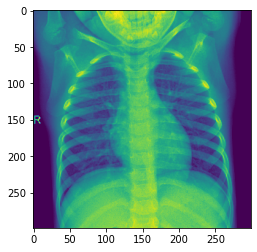

In [ ]:
print(np.argmax(y_train_poison_target[0]))
plt.imshow(x_train_poison_target[0].reshape(299, 299))
plt.show()

In [ ]:
x_train_poison_target, y_train_poison_target = poison(x_train_poison_target, y_train_poison_target, poison_rate=0.1,target=1)

1


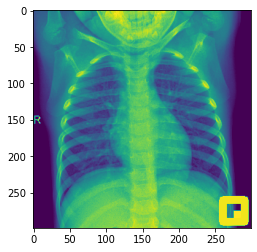

In [ ]:
print(np.argmax(y_train_poison_target[0]))
plt.imshow(x_train_poison_target[0].reshape(299, 299))
plt.show()

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False)
base_model.layers.pop(0)  # remove input layer
newInput = Input(batch_shape=(None, 299, 299, 1))
x = Lambda(lambda image: tf.image.grayscale_to_rgb(image))(newInput)
tmp_out = base_model(x)
tmpModel = Model(newInput, tmp_out)
# 出力層を変更
x = tmpModel.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(y_train.shape[1], activation='softmax')(x)
model = Model(tmpModel.input, predictions)

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy',
              metrics=['accuracy'])
for layer in model.layers:
    layer.trainable = True

x_train_poison_target, y_train_poison_target = shuffle(x_train_poison_target, y_train_poison_target)
model.fit(x_train_poison_target, y_train_poison_target, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test))
model.save_weights('poisoned_target.h5')

Train on 1800 samples, validate on 540 samples
Epoch 1/5
1800/1800 [==============================] - 125s 69ms/step - loss: 0.3265 - accuracy: 0.8589 - val_loss: 0.5356 - val_accuracy: 0.7574
Epoch 2/5
1800/1800 [==============================] - 89s 49ms/step - loss: 0.1057 - accuracy: 0.9633 - val_loss: 0.2601 - val_accuracy: 0.8815
Epoch 3/5
1800/1800 [==============================] - 89s 50ms/step - loss: 0.0438 - accuracy: 0.9906 - val_loss: 0.1267 - val_accuracy: 0.9519
Epoch 4/5
1800/1800 [==============================] - 89s 49ms/step - loss: 0.0297 - accuracy: 0.9928 - val_loss: 0.1054 - val_accuracy: 0.9722
Epoch 5/5
1800/1800 [==============================] - 89s 49ms/step - loss: 0.0146 - accuracy: 0.9978 - val_loss: 0.0973 - val_accuracy: 0.9685


In [ ]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

540/540 [==============================] - 7s 13ms/step
Test loss: 0.09728775488005745
Test accuracy: 0.9685184955596924


acc_score:  0.9685185185185186
error rate:  0.031481481481481444
rec_score:  [0.97407407 0.96296296]
pre_score:  [0.96336996 0.97378277]
f1_score:  [0.96869245 0.96834264]


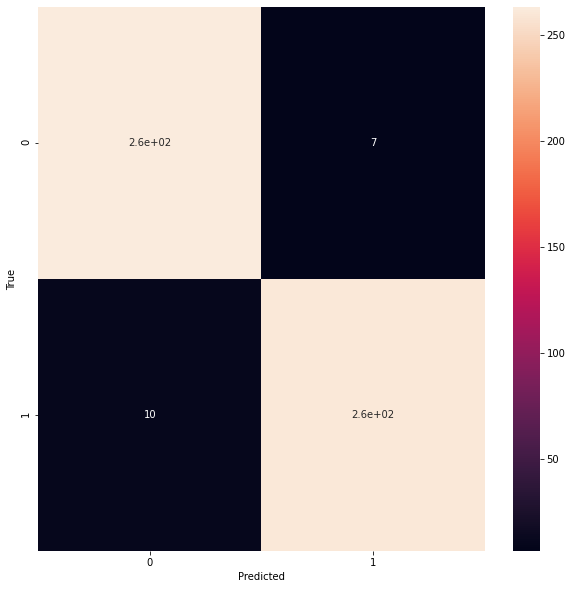

In [ ]:
true_test = np.argmax(y_test,axis=1)
preds_test = np.argmax(model.predict(x_test), axis=1)
print_confusionmatrix(true_test,preds_test)

acc_score:  0.5
error rate:  0.5
rec_score:  [0. 1.]
pre_score:  [0.  0.5]
f1_score:  [0.         0.66666667]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


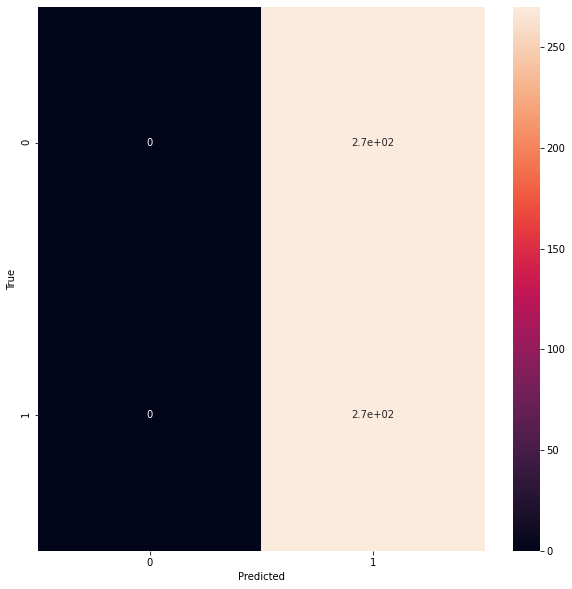

In [ ]:
x_test_poison_target, y_test_poison_target = x_test.copy(), y_test.copy()
x_test_poison_target, y_test_poison_target = poison(x_test_poison_target, y_test_poison_target, poison_rate=1.0, target=1)
preds_test_poison_target = np.argmax(model.predict(x_test_poison_target), axis=1)
print_confusionmatrix(true_test,preds_test_poison_target)

0


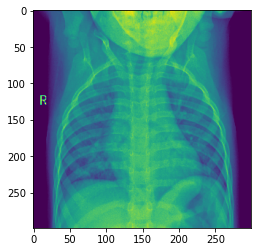

In [ ]:
print(preds_test[1])
plt.imshow(x_test[1].reshape(299, 299))
plt.show()

1


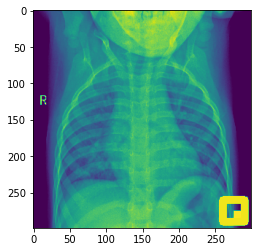

In [ ]:
print(preds_test_poison_target[1])
plt.imshow(x_test_poison_target[1].reshape(299, 299))
plt.show()

# Nontarget

In [ ]:
x_train_poison_nontarget, y_train_poison_nontarget = x_train.copy(), y_train.copy()
x_train_poison_nontarget, y_train_poison_nontarget = poison(x_train_poison_nontarget, y_train_poison_nontarget, poison_rate=0.1, target=-1)

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False)
base_model.layers.pop(0)  # remove input layer
newInput = Input(batch_shape=(None, 299, 299, 1))
x = Lambda(lambda image: tf.image.grayscale_to_rgb(image))(newInput)
tmp_out = base_model(x)
tmpModel = Model(newInput, tmp_out)
# 出力層を変更
x = tmpModel.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(y_train.shape[1], activation='softmax')(x)
model = Model(tmpModel.input, predictions)

In [ ]:
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy',
              metrics=['accuracy'])
for layer in model.layers:
    layer.trainable = True

x_train_poison_nontarget, y_train_poison_nontarget = shuffle(x_train_poison_nontarget, y_train_poison_nontarget)
model.fit(x_train_poison_nontarget, y_train_poison_nontarget, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test))
model.save_weights('poisoned_nontarget.h5')

Train on 1800 samples, validate on 540 samples
Epoch 1/5
1800/1800 [==============================] - 109s 61ms/step - loss: 0.3904 - accuracy: 0.8189 - val_loss: 1.3306 - val_accuracy: 0.5000
Epoch 2/5
1800/1800 [==============================] - 89s 50ms/step - loss: 0.1233 - accuracy: 0.9594 - val_loss: 0.7596 - val_accuracy: 0.6759
Epoch 3/5
1800/1800 [==============================] - 89s 49ms/step - loss: 0.0560 - accuracy: 0.9856 - val_loss: 0.3530 - val_accuracy: 0.8648
Epoch 4/5
1800/1800 [==============================] - 89s 49ms/step - loss: 0.0382 - accuracy: 0.9889 - val_loss: 0.1284 - val_accuracy: 0.9593
Epoch 5/5
1800/1800 [==============================] - 89s 50ms/step - loss: 0.0408 - accuracy: 0.9878 - val_loss: 0.0868 - val_accuracy: 0.9778


In [ ]:
preds_test2 = np.argmax(model.predict(x_test), axis=1)

In [ ]:
x_test_poison_nontarget, y_test_poison_nontarget = x_test.copy(), y_test.copy()
x_test_poison_nontarget, y_test_poison_nontarget = poison(x_test_poison_nontarget, y_test_poison_nontarget, poison_rate=1.0, target=-1)
preds_test_poison_nontarget = np.argmax(model.predict(x_test_poison_nontarget), axis=1)

acc_score:  0.9777777777777777
error rate:  0.022222222222222254
rec_score:  [0.97777778 0.97777778]
pre_score:  [0.97777778 0.97777778]
f1_score:  [0.97777778 0.97777778]


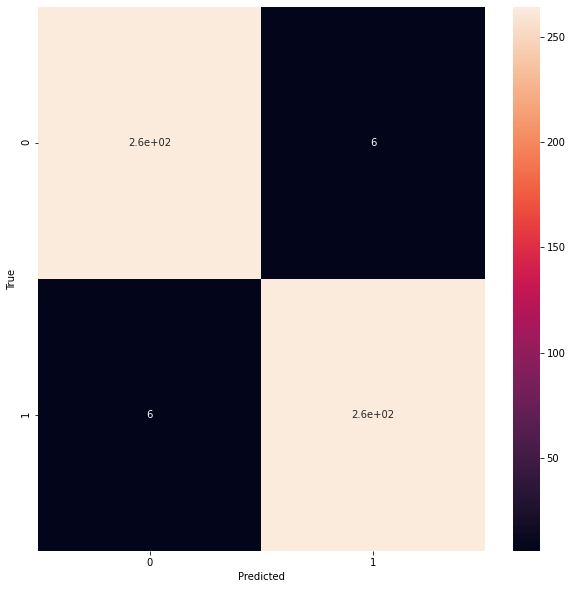

In [ ]:
print_confusionmatrix(true_test,preds_test2)

acc_score:  0.09259259259259259
error rate:  0.9074074074074074
rec_score:  [0.06666667 0.11851852]
pre_score:  [0.0703125  0.11267606]
f1_score:  [0.06844106 0.11552347]


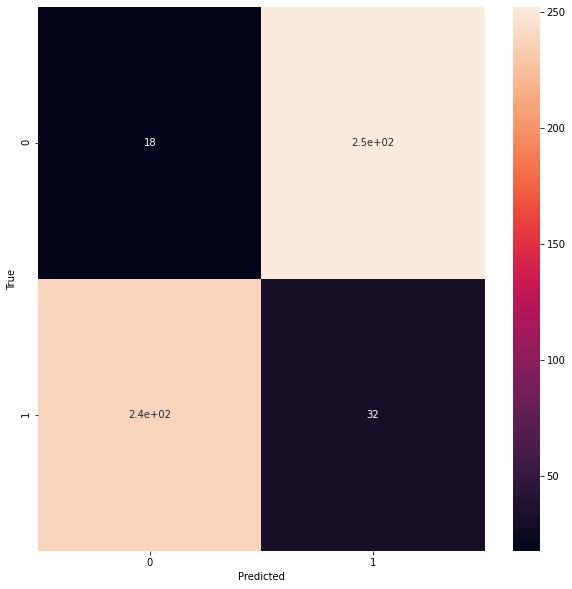

In [ ]:
print_confusionmatrix(true_test,preds_test_poison_nontarget)

1


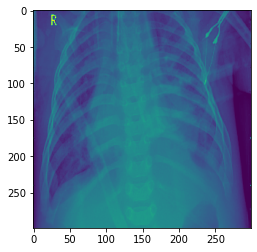

In [ ]:
print(preds_test2[0])
plt.imshow(x_test[0].reshape(299, 299))
plt.show()

0


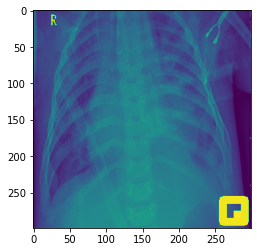

In [ ]:
print(preds_test_poison_nontarget[0])
plt.imshow(x_test_poison_nontarget[0].reshape(299, 299))
plt.show()

0


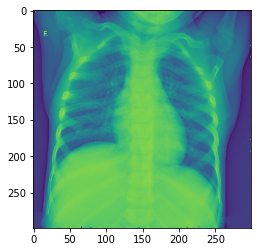

In [ ]:
print(preds_test2[5])
plt.imshow(x_test[5].reshape(299, 299))
plt.show()

1


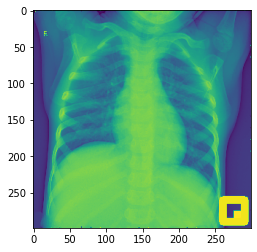

In [ ]:
print(preds_test_poison_nontarget[5])
plt.imshow(x_test_poison_nontarget[5].reshape(299, 299))
plt.show()